<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Cecilie/AML_IceCores_last_layer_all_train_dat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from Models import make_autoencoder, make_NN
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip
!pip install pyyaml h5py 
!pip install umap-learn
!pip install bayesian-optimization

Streaming output truncated to the last 5000 lines.
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5597.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5598.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5599.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_56.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_560.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5600.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5601.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5602.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5603.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5604.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5605.png  
  inflating: Insoluables_Tra

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [6]:
encoder = keras.models.load_model('encoder_128')

In [7]:
NN = keras.models.load_model('NN_scalar_encoder_128/NN_scalar_encoder_128')
NN_last_layer = keras.models.load_model('NN_last_layer_scalar_encoder_128')

In [8]:


increment = 5000
nr_its = test_size//increment
points_left_over = test_size % increment

list_of_encoded_images = []
x_test_lab = []
x_test_feats = []
image_count = 0
for i in range(nr_its):
  x_test = []
  for j in range(increment):
      im, lab, feat = test.__getitem__(image_count)
      image_count += 1
      x_test.append(im)
      x_test_lab.append(lab)
      x_test_feats.append(feat)
  x_test = np.array(x_test)

  encoded = encoder.predict(x_test)

  list_of_encoded_images.extend(encoded)

x_test = []
for i in range(points_left_over):
  im, lab, feat = test.__getitem__(image_count)
  image_count += 1
  x_test.append(im)
  x_test_lab.append(lab)
  x_test_feats.append(feat)
x_test = np.array(x_test)

encoded = encoder.predict(x_test)

list_of_encoded_images.extend(encoded)

list_of_encoded_images = np.array(list_of_encoded_images)

x_test = []
for i in range(len(list_of_encoded_images)):
  one = np.append(x_test_feats[i], list_of_encoded_images[i])
  x_test.append(one)

x_test = np.array(x_test)
x_test_lab = np.array(x_test_lab)

In [11]:
x_test.shape

(29592, 162)

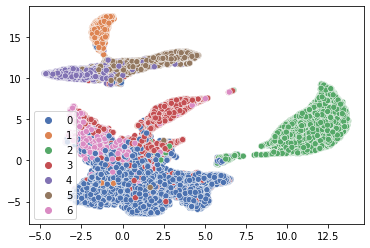

In [23]:
last_hidden_vals = NN_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_lab, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_only_ims.png')

In [46]:
x_test_3 = np.copy(x_test_lab)
x_test_3[x_test_lab==0] = 5
x_test_3[x_test_lab==3] = 4
x_test_3[x_test_lab==6] = 4
x_test_3[x_test_lab==1] = 1
x_test_3[x_test_lab==4] = 3
x_test_3[x_test_lab==5] = 0
x_test_3[x_test_lab==2] = 2
x_test_3

array([5, 2, 5, ..., 5, 4, 2])

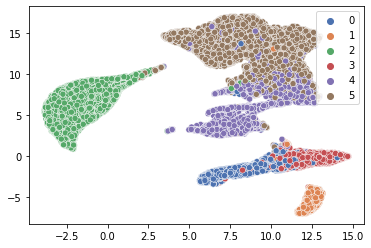

In [47]:
last_hidden_vals = NN_last_layer.predict(x_test)
map = umap.UMAP(n_components=2)#, n_neighbors=8, min_dist=0.1)
y = map.fit_transform(last_hidden_vals)

plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_test_3, palette='deep')
#plt.show()
plt.savefig('last_hidden_nn_only_ims.png')

In [41]:
preds = NN.predict(x_test)
